<a href="https://colab.research.google.com/github/Adi-iitd/Super-Convergence-of-Neural-Nets/blob/master/Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import important libraries
import numpy as np; np.random.seed(42); import tensorflow as tf; tf.set_random_seed(42); 
from sklearn.preprocessing import LabelBinarizer; import os; from os import listdir;
from matplotlib import pyplot as plt; import pylab; import cv2;
%matplotlib inline

# Suppress the irrelevant warnings
import warnings; warnings.filterwarnings("ignore");

In [0]:
batch_sz = 512; lab_bin = LabelBinarizer(); log_path = "FMNIST/"; colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c'];

# Make the directory if it doesn't exists
if not os.path.exists(log_path): os.makedirs(log_path); 

# Load the train and test data and do the 0-1 scaling
data_ld = tf.keras.datasets.fashion_mnist; (X_train_val, y_train_val), (X_test, y_test) = data_ld.load_data();
img_height = X_test.shape[1]; img_width = X_test.shape[2]; img_channels = 1 if len(X_test.shape) == 3 else 3; 

X_train_val = X_train_val/255.; X_test = X_test/255.; 
if img_channels == 1: X_train_val = np.expand_dims(X_train_val, axis = 3); X_test = np.expand_dims(X_test, axis = 3);

# Get the One-hot encoding of the target variable
y = np.concatenate((y_train_val, y_test), axis = 0); y = lab_bin.fit_transform(y); 

# Split the whole dataset in Train, Val and Test set
test_sz = X_test.shape[0]; X_train, X_val =  X_train_val[0:-1*test_sz, :], X_train_val[-1*test_sz:, :]; 
y_train, y_val, y_test = y[0:-2*test_sz, :], y[-2*test_sz:-1*test_sz, :], y[-1*test_sz:, :];

num_train_iters = X_train.shape[0]//batch_sz; num_val_iters = num_test_iters = X_test.shape[0]//batch_sz;

In [0]:
# Code to get the nice visualizations on the tensorboard

get_ipython().system_raw('tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format(log_path))
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

In [0]:
def summary(var, name):
    
    """
    Arguments:
    var:  Variable whose summary will get plotted on tensorboard
    name: Variable's name that will be assigned to it
    
    """  
    
    with tf.variable_scope(name):
#       Mean and Standard Deviation of the variable 
        mu = tf.reduce_mean(var); sigma = tf.sqrt(tf.reduce_mean(tf.square(var - mu)));
#       Histogram plot of the variable
        tf.summary.histogram('Histogram', var); 
        tf.summary.scalar("Mean", mu); tf.summary.scalar("Std_dev", sigma);
  
  
def get_dataset(tensor):
    
    """
    Arguments:
    Tensor:  Simple or Nested structures of tensors 
    
    Returns:
    Dataset: Dataset format of the above tensor 
    """
    
    dataset = tf.data.Dataset.from_tensor_slices(tensor);
    return dataset

  
def get_aug_image(image, label):
    
    """
    Arguments:
    image: Original image to which to apply arbitrary distortions
    label: Original label of the image
    
    Returns:
    image: Distorted version of the original image
    """
    
#   Apply different augmentation techniques
    image = tf.image.random_flip_left_right(image); 
    image = tf.image.resize_image_with_crop_or_pad(image, img_height + 2, img_width + 2); 
    image = tf.random_crop(image, [img_height, img_width, img_channels]); 
    
    image = tf.image.random_brightness(image, max_delta = 32.0 / 255.0); 
    image = tf.image.random_contrast(image, lower = 0.5, upper = 1.5);
    if img_channels == 3: image = tf.image.random_saturation(image, lower = 0.5, upper = 1.5);
    
    image = tf.clip_by_value(image, 0., 1.)

    return image, label

  
def get_dataset_iterators(sess):
  
    """
    Arguments:
    sess:           Session of tensorflow
    
    Returns:
    handle:         A scalar tf.Tensor of type tf.string that evaluates to a handle 
    next_element:   A nested structure of tf.Tensors representing the next element
    train_iterator: Iterator corresponding to the training dataset
    train_handle:   String-valued tf.Tensor that represents the train iterator
    """
    
#   Create the dataset versions of the original tensors
    train_dataset = get_dataset((X_train, y_train)); 
    val_dataset = get_dataset((X_val, y_val)); 
    test_dataset = get_dataset((X_test, y_test));
  
#   Apply augmentation techniques to get the distorted version of the original dataset 
#   Randomly shuffle the training dataset, batch them and then prefetch them 
    train_dataset = train_dataset.shuffle(50000).repeat(); 
    train_dataset = train_dataset.map(get_aug_image, num_parallel_calls = 4);
    train_dataset = (train_dataset.batch(batch_sz)).prefetch(1); 
    
    val_dataset = (val_dataset.batch(batch_sz)).prefetch(1); 
    test_dataset = (test_dataset.batch(batch_sz)).prefetch(1);
    
#   Create the iterators
    handle = tf.placeholder(tf.string, shape = []);
    iterator = tf.data.Iterator.from_string_handle(handle, train_dataset.output_types, train_dataset.output_shapes); 
    next_element = iterator.get_next()
    
    train_iterator = train_dataset.make_initializable_iterator(); 
    train_handle = sess.run(train_iterator.string_handle()); 
    
    val_iterator = val_dataset.make_initializable_iterator(); 
    val_handle = sess.run(val_iterator.string_handle());
    
    test_iterator = test_dataset.make_initializable_iterator(); 
    test_handle = sess.run(test_iterator.string_handle());

    return handle, next_element, train_iterator, train_handle, val_iterator, val_handle, test_iterator, test_handle;

In [0]:
def conv_2d(x, kernel_size = 3, stride = 1, out_channels = 64, is_conv = True, is_norm = True, normalization = 'batch', is_act = True, 
			      activation = 'relu', leak_param = 1/5.5):
  
    """
    Arguments:
    x:             Input Tensor
    kernel_size:   Integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window
    stride:        Integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width
    out_channels:  Integer, the dimensionality of the output space
    is_conv:       Boolean, whether to perform convolution or not
    is_norm:       Boolean, whether to normalize the data or not
    normalization: Type of normalization, supports batch and instance normalization
    is_act:        Boolean, whether to apply non-linear activation functions or not
    activation:    Type of activation function, supports Leaky_ReLU, ReLU and Elu
    leak_param:    Integer, Leakiness to use in case of Leaky ReLU
    
    Returns:
    x:             Output Tensor
    """
    
#   Apply Convolution
    if is_conv:
        x = tf.layers.conv2d(x, filters = out_channels, kernel_size = kernel_size, strides = stride, padding = 'SAME', 
                             use_bias = False, kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d())
      
#   Apply Normalization
    if is_norm:
        if(normalization == 'instance'): x = tf.contrib.layers.instance_norm(x, epsilon = 1e-6)
        elif(normalization == 'batch'): x = tf.layers.batch_normalization(x, epsilon = 1e-5, training = train_mode, momentum = 0.9)
    
#   Apply Non-linearities
    if is_act:
        if activation == 'lrelu': x = tf.nn.leaky_relu(x, leak_param);
        if activation == 'elu': x = tf.nn.elu(x, name = "elu");
        elif activation == 'relu': x = tf.nn.relu(x, name = "relu")

    return x
  
  
def wide_resblk_1(inp_ten, stride = 2, in_channels = 16, widen_factor = 2, activation = 'relu', normalization = 'batch', 
				          leak_param = 1/5.5, name = None):   
    
    """
    Arguments:
    inp_ten:       Input tensor
    Stride:        Integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width
    in_channels:   Number of base filters in convolutional layer
    widen_factor:  Factor by which to widen the number of base filters
    activation:    Type of activation function, supports Leaky_ReLU, ReLU and Elu
    normalization: Type of normalization, supports batch and instance normalization
    leak_param:    Integer, Leakiness to use in case of Leaky ReLU
    name:          Name to be used inside variable scope 
    
    Returns:
    output:       Output tensor
    """
    
    with tf.variable_scope(name):

#       Normalize and apply activation on the input tensor 
        with tf.variable_scope("Input_tensor"):
            inp_ten = conv_2d(inp_ten, is_conv = False, activation = activation, normalization = normalization, leak_param = leak_param)
      
#       Two convolutional layers (first one can be optional stridden convolution) in the main path with a dropout layer in between them
        with tf.variable_scope("Conv1_layer"):
            blk_1 = conv_2d(inp_ten, 3, stride, in_channels*widen_factor, activation = activation, normalization = normalization,
                            leak_param = leak_param);
      
            blk_1 = tf.nn.dropout(blk_1, keep_prob = (1-dropout))

        with tf.variable_scope("Conv2_layer"):
            blk_1 = conv_2d(blk_1, 3, 1, in_channels*widen_factor, is_norm = False, is_act = False)

#       One convolutional layer (without normalization and activation) in the skip connection layer
        with tf.variable_scope("Skip_connec"):
            blk_2 = conv_2d(inp_ten, 1, stride, in_channels*widen_factor, is_norm = False, is_act = False);

        output = blk_1 + blk_2
        return output
      

def wide_resblk_2(inp_ten, activation = 'relu', leak_param = 1/5.5, name = None):    
    
    with tf.variable_scope(name):
      
        in_channels = inp_ten.get_shape()[-1]
        with tf.variable_scope("Norm_and_act"):
            blk_1 = conv_2d(inp_ten, is_conv = False, activation = activation, leak_param = leak_param)

        with tf.variable_scope("Conv1_layer"):
            blk_1 = conv_2d(blk_1, 3, 1, in_channels, activation = activation, leak_param = leak_param)
            blk_1 = tf.nn.dropout(blk_1, keep_prob = (1-dropout))

        with tf.variable_scope("Conv2_layer"):
            blk_1 = conv_2d(blk_1, 3, 1, in_channels, is_norm = False, is_act = False)

        return blk_1 + inp_ten

In [0]:
def model(input_ten, init_out_channels = 64, normalization = 'batch', activation = 'relu', leak_param = 1/5.5):
    
    """
    Arguments:
    input_ten:         Input tensor
    init_out_channels: Number of filters in the first layer of convolution
    activation:        Type of activation function, supports Leaky_ReLU, ReLU and Elu
    normalization:     Type of normalization, supports batch and instance normalization
    leak_param:        Integer, Leakiness to use in case of Leaky ReLU
    
    Returns:
    x:                 Output tensor 
    """
    
#   Model architecture (1 conv -> 1 WR_blk_1 -> n WR_blk_2 -> 1 WR_blk_1 -> n WR_blk_2 -> 1 WR_blk_1 -> n WR_blk_2 -> 
#   Global_avg_pooling -> Dense) 
    
    num_blocks = 0;
    with tf.variable_scope("Block_0"):
        x = conv_2d(input_ten, 3, 1, init_out_channels, is_act = False, is_norm = False);
        summary(x, "Block_" + str(num_blocks)); num_blocks += 1;

    x = wide_resblk_1(x, stride = 1, in_channels = 16, widen_factor = 8, name = "Block_" + str(num_blocks)); num_blocks += 1;
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding = "SAME");
    for i in range(1): x = wide_resblk_2(x, name = "Block_" + str(num_blocks)); num_blocks += 1;

    x = wide_resblk_1(x, stride = 2, in_channels = 32, widen_factor = 8, name = "Block_" + str(num_blocks)); num_blocks += 1;
    for i in range(1): x = wide_resblk_2(x, name = "Block_" + str(num_blocks)); num_blocks += 1;

    x = wide_resblk_1(x, stride = 2, in_channels = 64, widen_factor = 8, name = "Block_" + str(num_blocks)); num_blocks += 1;
    for i in range(1): x = wide_resblk_2(x, name = "Block_" + str(num_blocks)); num_blocks += 1; 

    x = conv_2d(x, is_conv = False, activation = activation, normalization = normalization); 
    x = tf.reduce_mean(x, axis = [1, 2], keepdims = True); x = tf.layers.flatten(x); 

    with tf.variable_scope("Output_layer"):
        x = tf.layers.dense(x, 10, kernel_initializer = tf.contrib.layers.xavier_initializer()); num_blocks += 1;
        var_list = [var for var in tf.trainable_variables() if ("Block_0" in var.name or "Output_layer" in var.name) and "kernel" in var.name]
        for ind, var in enumerate(var_list): summary(var, 'Kernel_' + str(ind));

    return x

In [0]:
def compute_loss(logits, labels): 
    
    """
    Arguments:
    logits: Unscaled log probabilities
    labels: One-hot vectors
    
    Returns:
    loss:   Tensor that contains the softmax cross entropy loss
    """
    
#   compute the softmax cross entropy loss  
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = labels))
    return loss
  
  
def training(loss, wt_dec):
      
    """
    Arguments:
    loss:     Tensor that contains the softmax cross entropy loss
    wt_dec:   Weight_decay value to be used inside the optimizer
    
    Returns:
    train_op: Initialization of Momentum with weight decay optimizer
    """
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        
#       compute the gradients for each variable wrt the loss function and zip them
        grads = tf.gradients(loss, tf.trainable_variables()); grads_and_vars = list(zip(grads, tf.trainable_variables()))
  
#       initialize the optimizer
        optimizer = tf.contrib.opt.MomentumWOptimizer(weight_decay = wt_dec, learning_rate = lr_ph, momentum = beta1_ph, use_nesterov = True)
  
#       Don't apply weight decay to bias and batch_norm parameters
        var_list = [var for var in tf.trainable_variables() if ("batch_normalization" or "bias") not in var.name];
        train_op = optimizer.apply_gradients(grads_and_vars = grads_and_vars, decay_var_list = None)

    return train_op
  

def accuracy(y_pred, y_true):
  
    """
    Arguments:
    y_pred: Predicted values of the target variable
    y_true: True values of the target variable
    
    Returns:
    accuracy: accuracy computed using tf.equal 
    """
    y_pred = tf.argmax(y_pred, axis = 1); y_true = tf.argmax(y_true, axis = 1); 
    accuracy = tf.reduce_mean(tf.cast(tf.equal(y_pred, y_true), dtype = tf.float32))
    return accuracy
  
  
def initialize_model(): 
  
    """
    Returns:
    logits: Un-normalized probabilities
    loss:   Loss 
    acc:    Accuarcy
    """
    
#   Initialize the model
    with tf.name_scope("Placeholders"):
    
#       Defining global variables that need to be passed within many functions 
        global X_ph, y_ph, lr_ph, beta1_ph, train_mode, dropout;
        X_ph = tf.placeholder(dtype = tf.float32, shape = [None,  img_height, img_width, img_channels], name = "Input_image"); 
        y_ph = tf.placeholder(dtype = tf.float32, shape = [None, 10], name = "Input_Labels"); 
        dropout = tf.placeholder(dtype = tf.float32, name = "Dropout"); 
        lr_ph = tf.placeholder(dtype = tf.float32, name = "Learning_rate"); 
        train_mode = tf.placeholder(dtype = tf.bool, name = 'Train_Mode_BN');  
        beta1_ph = tf.placeholder(shape = [], dtype = tf.float32);
        
#   compute logits, loss and accuracy
    logits = model(X_ph); loss = compute_loss(logits, y_ph); acc = accuracy(logits, y_ph); 
    return logits, loss, acc

  
def smooth(x, window_len = 11, window = 'flat'):
    
    """
    Arguments:
    x:          Input tensor
    window_len: Length of the window to consider while smoothing
    Returns:
    y:          Smoothed version of x
    
    """
    
#   use np.convolve to get a smoothed version of the input array considering window_len number of elements while doing convolution
    if window_len<3: return x     
    s = np.r_[x[window_len-1:0:-1], x, x[-2:-window_len-1:-1]]
    if window == 'flat': w = np.ones(window_len, 'd')
    else: w = eval('numpy.' + window + '(window_len)')
    y = np.convolve(w/w.sum(), s, mode = 'valid')
    return y
    
    
def plot_graph(learning_rate_collection, val_loss_collection, name, color):  
  
    """
    Arguments:
    learning_rate_collection: List of learning_rates used while training the Neural Network
    val_loss_collection:      List of validation loss that we obtained after evaluating the trained Neural Network on validation set
    name:                     Optional name of the operation
    color:                    Color to be used while plotting
    
    Returns: a plot 
    """
    
    pylab.plot(val_loss_collection[:len(learning_rate_collection)], color, label = name);
    plt.xticks(range(len(learning_rate_collection)), np.around(np.log10(learning_rate_collection), decimals = 2)); 
    pylab.legend(loc = 'upper left');
  
  
def lr_mom_calculator(num_epochs, max_lr, min_lr = None, train = False):  
  
    
    """
    Arguments:
    num_epochs:               Number of epochs to run              
    max_lr:                   Max learning rate in one-cycle policy
    min_lr:                   Min learning rate in one-cycle policy
    train:                    Boolean, whether the model is running in train mode or Grid_SearchCV mode  
    
    Returns:
    learning_rate_collection: Linear(Incr -> Decr) Learning rate collection 
    momentum_collection:      Linear(Decr -> Incr) Momentum collection
    """
    
    tot_iters = int(num_epochs*num_train_iters); 
    learning_rate_collection = np.zeros(tot_iters + 1); momentum_collection = np.zeros(tot_iters + 1);
    
    if min_lr == None: min_lr = max_lr/20;

#   In last few epochs, decaying the minimum learning rate by several orders of magnitude
    thresh = min_lr/1000; max_mom = 0.95; min_mom = 0.85; 
    num_iters_2 = int(num_epochs*num_train_iters/7.5); num_iters_1 = (tot_iters - num_iters_2)//2;
    
#   Increase the learning rate and decrease the momentum in the first part of the training
    for ind in range(num_iters_1):
        learning_rate_collection[ind] = min_lr + ((max_lr - min_lr)/num_iters_1)*ind;
        momentum_collection[ind] = min_mom - ((max_mom - min_mom)*(ind - num_iters_1))/num_iters_1;
    
#   Decrease the learning rate and increase the momentum in the second part of the training
    for ind in range(num_iters_1, 2*num_iters_1):
        learning_rate_collection[ind] = min_lr + ((max_lr - min_lr)/(num_iters_1))*(2*num_iters_1 - ind);
        momentum_collection[ind] = min_mom + ((max_mom - min_mom)*(ind - num_iters_1))/num_iters_1;
        
#   Decrease the learning rate to several orders of magnitude and keep the momentum constant in the last part of the training
    for ind in range(2*num_iters_1, tot_iters):
        learning_rate_collection[ind] = thresh + ((min_lr - thresh)/(num_iters_2))*(tot_iters - ind);
        momentum_collection[ind] = max_mom
    
#   Run Grid_Search_CV only for the increasing part of the learning rate schedule 
    if not train: return learning_rate_collection[: num_iters_1], momentum_collection[: num_iters_1];
    else: return learning_rate_collection, momentum_collection

In [0]:
def Lr_finder(epochs = 10, min_lr = 1e-5, max_lr = 10, params = ['Lr_finder'], fin_wt_dec = 0, fin_dropout = 0, vanilla = False, 
              wt_dec_gridsearch = False, dropout_gridsearch = False):
    
    """
    Arguments:
    epochs:             Number of epochs to run
    min_lr:             Max_learning rate in one-cycle policy
    max_lr:             Min_learning rate in one-cycle policy
    params:             Grid Search parameters
    fin_wt_dec:         Constant weight decay value to be used while training
    fin_dropout:        Constant dropout value to be used while training
    vanilla:            Boolean, whether to run vanilla LR_finder
    wt_dec_gridsearch:  Boolean, whether to run grid search over wt_decay values
    dropout_gridsearch: Boolean, whether to run grid search over dropout values
    """
    
#   Get the learning rate collection corresponding to the first part of the training
    plt.figure(figsize = (20, 10)); epochs = epochs*2;
    for ind, val in enumerate(params):
        
        g_lr_finder = tf.get_default_graph();
        with g_lr_finder.as_default():
      
            tf.set_random_seed(42); 
            with tf.Session(graph = g_lr_finder) as sess:
            
#               Initialize the model
                logits, loss, accuracy = initialize_model();
  
#               Run Grid_Search for wt_dec values if boolean wt_dec_gridsearch is true 
                if wt_dec_gridsearch: print('Grid_Search statrted corresponding to wt_dec: ' + str(val)); train_step = training(loss, val);
                else: train_step = training(loss, fin_wt_dec);
          
#               Run Grid_Search for Dropout values if boolean dropout_gridsearch is true
                if dropout_gridsearch: print('Grid_Search statrted corresponding to dropout: ' + str(val)); drop_prob = val;
                else: drop_prob = fin_dropout;
                  
#               Run Vanilla LR_finder if boolean vanilla is true
                if vanilla: print("Vanilla Lr_finder Started:"); 

#               Get the iterators, LR collection and momentum collection
                handle, next_element, train_iter, train_handle, val_iter, val_handle, test_iter, test_handle = get_dataset_iterators(sess); 
                learning_rate_collection = []; val_acc_collection = []; 
    
                sess.run([tf.global_variables_initializer()]); sess.run(train_iter.initializer); 
                lr_coll, mom_coll = lr_mom_calculator(epochs, max_lr, min_lr, False);

                for ptr in range(len(lr_coll)):
                  
                    curr_lr = lr_coll[ptr]; curr_beta1 = mom_coll[ptr];
                    try: X_train_batch, y_train_batch = sess.run(next_element, feed_dict = {handle: train_handle});
                    except tf.errors.OutOfRangeError: sess.run(train_iter.initializer)
                    
#                   Run the training step to update the parameters and collect loss and acc values
                    _, train_loss, train_acc = sess.run([train_step, loss, accuracy], feed_dict = {X_ph: X_train_batch, y_ph: y_train_batch, 
                                                        lr_ph: curr_lr, train_mode: True, beta1_ph: curr_beta1, dropout: drop_prob})
  
#                   Evaluate the trained model on eval set after every certain number of iterations
                    if ptr % 25 == 0 and ptr > num_train_iters:
                        sess.run(val_iter.initializer); tot_val_loss = 0; tot_val_acc = 0;
                        for val_ptr in range(num_val_iters + 1):
                  
#                           Grab a batch of Validation set and calculate running sum of some useful statistics
                            try: X_val_batch, y_val_batch = sess.run(next_element, feed_dict = {handle: val_handle}); 
                            except tf.errors.OutOfRangeError: sess.run(val_iter.initializer);

                            val_loss, val_acc = sess.run([loss, accuracy], feed_dict = {X_ph: X_val_batch, y_ph: y_val_batch, train_mode: False,
                                                                                        dropout: 0});
          
                            tot_val_loss += val_loss; tot_val_acc += val_acc;
            
                        val_acc_collection.append(tot_val_acc/(num_val_iters + 1)); learning_rate_collection.append(curr_lr); 
            
#               Get a smoothed version of the accuracy plot!!
                val_acc_collection_smooth = smooth(val_acc_collection); 
                plot_graph(learning_rate_collection, val_acc_collection_smooth, str(val), colors[ind]); 
            
#           Terminate the Session"""
            sess.close();
          
#       Reset the default graph in order to ensure that weights of the network at start are random for each Grid_search_param"""
        tf.reset_default_graph(); 
        
#   Show the plot
    plt.show()

Vanilla Lr_finder Started:


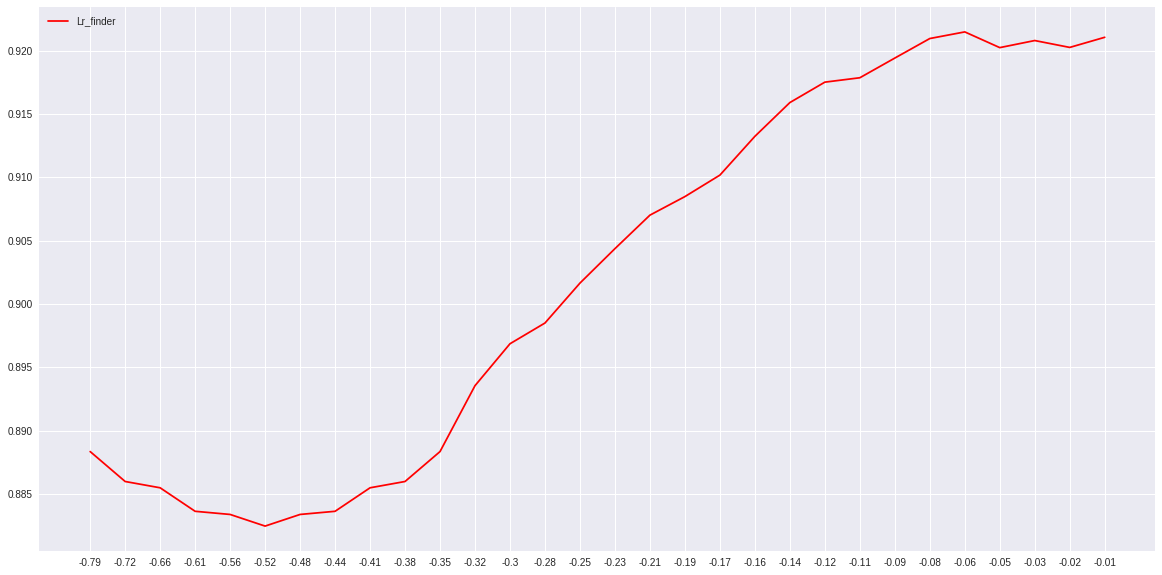

In [9]:
# Run the Vanilla LR_finder
tf.reset_default_graph(); Lr_finder(epochs = 10, max_lr = 1, min_lr = 5e-2, vanilla = True);

Grid_Search statrted corresponding to wt_dec: 1e-05
Grid_Search statrted corresponding to wt_dec: 3.18e-05
Grid_Search statrted corresponding to wt_dec: 0.0001


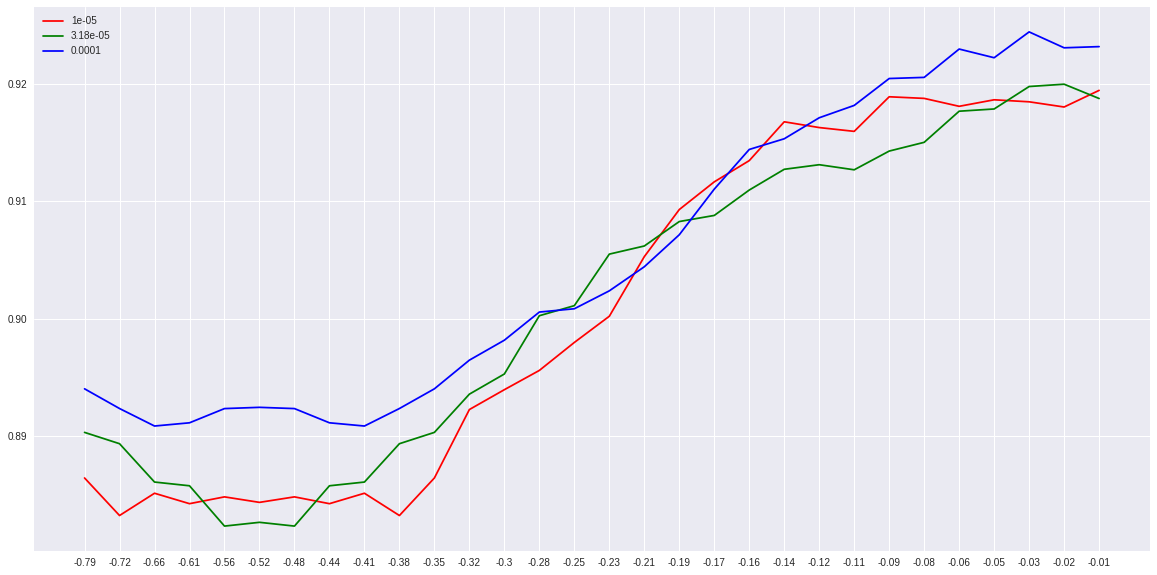

In [11]:
# Run the Grid_Search_CV for wt_dec values
tf.reset_default_graph(); wt_dec_list = [1e-5, 3.18e-5, 1e-4];
Lr_finder(epochs = 10, max_lr = 1, min_lr = 5e-2, params = wt_dec_list, wt_dec_gridsearch = True)

Grid_Search statrted corresponding to dropout: 0.15
Grid_Search statrted corresponding to dropout: 0.3
Grid_Search statrted corresponding to dropout: 0.45


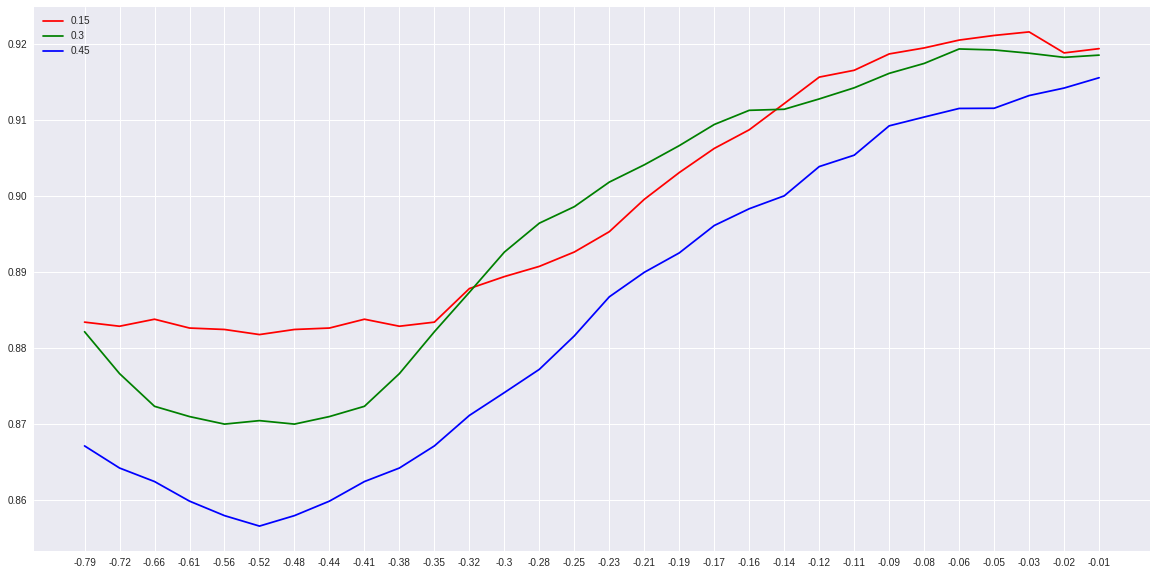

In [12]:
# Run the Grid_Search_CV for Dropout values
tf.reset_default_graph(); dropout_list = [0.15, 0.3, 0.45];
Lr_finder(epochs = 10, max_lr = 1, min_lr = 5e-2, params = dropout_list, fin_wt_dec = 1e-4, dropout_gridsearch = True)

In [0]:
def train(num_epochs):
  
    """
    Arguments:
    epochs:  Number of epochs to run
    
    Returns: None     
    """

#   Define a graph and set it to default one 
    g_train = tf.get_default_graph();
    with g_train.as_default():

#       Define a Session
        with tf.Session(graph = g_train) as sess:

            tf.set_random_seed(42);
      
#           Initialize the model and the variables whose statistics are to be plotted
            logits, loss, acc = initialize_model(); tf.summary.scalar("Loss", loss); tf.summary.scalar("Accuracy", acc); 
            
#           Define the training step and iterators over the dataset
            train_step = training(loss, 1e-4);
            handle, next_element, train_iter, train_handle, val_iter, val_handle, test_iter, test_handle = get_dataset_iterators(sess); 
            sess.run([tf.global_variables_initializer()]); lr_coll, mom_coll = lr_mom_calculator(num_epochs, 1, 5e-2, True); 
      
#           Define the saver and writer which will be writing the logs at the specified location (again for Tensorboard) 
            saver = tf.train.Saver(max_to_keep = 10); 
            merged = tf.summary.merge_all(); writer = tf.summary.FileWriter(log_path, sess.graph)

            print('Training statrted...');

            for epoch in range(1, num_epochs + 1):
          
#               Initialize the training iterator 
                sess.run(train_iter.initializer); tot_train_loss = 0; tot_train_acc = 0;
                for train_ptr in range(num_train_iters + 1):
      
                    try: X_train_batch, y_train_batch = sess.run(next_element, feed_dict = {handle: train_handle});
                    except tf.errors.OutOfRangeError: sess.run(train_iter.initializer)  
              
#                   Run the training step to update the parameters
                    _, train_loss, train_acc = sess.run([train_step, loss, acc], feed_dict = {X_ph: X_train_batch, y_ph: y_train_batch,
                                                         train_mode: True, dropout: 0.15, lr_ph: lr_coll[(epoch-1)*num_train_iters + train_ptr], 
                                                         beta1_ph: mom_coll[(epoch-1)*num_train_iters + train_ptr]})
  
                    tot_train_loss += train_loss; tot_train_acc += train_acc;
    
#               Evaluate the trained model on eval set if the condition is satisfied
                sess.run(val_iter.initializer); tot_val_loss = 0; tot_val_acc = 0;
                for val_ptr in range(num_val_iters + 1):
      
                    try: X_val_batch, y_val_batch = sess.run(next_element, feed_dict = {handle: val_handle})
                    except tf.errors.OutOfRangeError: sess.run(val_iter.initializer)

                    val_loss, val_acc, summary = sess.run([loss, acc, merged], feed_dict = {X_ph: X_val_batch, y_ph: y_val_batch, 
                                                                                            train_mode: False, dropout: 0})
                
                    tot_val_loss += val_loss; tot_val_acc += val_acc; 
                
                writer.add_summary(summary, epoch);
                print(str(epoch) + ' Epochs:: Train_loss: ' + str(tot_train_loss/(num_train_iters + 1)) + ', Val_loss: ' + \
                      str(tot_val_loss/(num_val_iters + 1)) + ', Train_acc: ' + str((tot_train_acc/(num_train_iters + 1))*100) \
                      + '%, Val_acc: ' + str(tot_val_acc/(num_val_iters + 1)*100) + '%')

#               Evaluate the trained model on the test set after every 5 epochs
#               NOTE: This is not introducing any leakage of statistics from train/Val set into the test set by any means, just evaluating 
#                     it on the test set after every 5 epochs to have a rough idea of what's going on.
                if epoch % 5 == 0:	
    
                    sess.run(test_iter.initializer); tot_test_loss = 0; tot_test_acc = 0;
                    for test_ptr in range(num_test_iters + 1):
          
                        try: X_test_batch, y_test_batch = sess.run(next_element, feed_dict = {handle: test_handle})
                        except tf.errors.OutOfRangeError: sess.run(test_iter.initializer)

                        test_loss, test_acc = sess.run([loss, acc], feed_dict = {X_ph: X_test_batch, y_ph: y_test_batch, 
                                                                                 train_mode: False, dropout: 0});
                    
                        tot_test_loss += test_loss; tot_test_acc += test_acc;
                    print('Test_loss: ' + str(tot_test_loss/(num_test_iters + 1)) + ', Test_acc: ' + str(tot_test_acc/(num_test_iters + 1)))
                    
#               Save the checkpoints at the specified directory!!!
#                 if(epoch % 5 == 0): saver.save(sess, log_path + 'Ckpts', global_step = epoch)

        sess.close();  """ Close the Session """
      
    tf.reset_default_graph();  """ Reset the default graph """

In [14]:
# Train the model for n number of epochs!
tf.reset_default_graph(); train(75);

Training statrted...
1 Epochs:: Train_loss: 0.6195252254909399, Val_loss: 0.3531673550605774, Train_acc: 77.50916772959184%, Val_acc: 87.18347877264023%
2 Epochs:: Train_loss: 0.32039522121147235, Val_loss: 0.2841761611402035, Train_acc: 88.32708864795919%, Val_acc: 89.51114416122437%
3 Epochs:: Train_loss: 0.27593659898456263, Val_loss: 0.2514152660965919, Train_acc: 89.99322385204081%, Val_acc: 91.04607075452805%
4 Epochs:: Train_loss: 0.25340327848585287, Val_loss: 0.21824700236320496, Train_acc: 90.73062818877551%, Val_acc: 91.865234375%
5 Epochs:: Train_loss: 0.2335153281384585, Val_loss: 0.22437647506594657, Train_acc: 91.34845344387756%, Val_acc: 91.76470577716827%
Test_loss: 0.23825721815228462, Test_acc: 0.9128733903169632
6 Epochs:: Train_loss: 0.2205028314979709, Val_loss: 0.23690344095230104, Train_acc: 91.97823660714286%, Val_acc: 91.36833637952805%
7 Epochs:: Train_loss: 0.2095839619940641, Val_loss: 0.19674964398145675, Train_acc: 92.37683354591837%, Val_acc: 92.81364887